In [1]:
!pwd

/content


In [2]:
cd /content/drive/MyDrive/rohit-tech-work/image_super_resolution/codes

/content/drive/.shortcut-targets-by-id/1ONKzZRQrdbwZEGFgDw8qOg1GJVE828hi/rohit-tech-work/image_super_resolution/codes


In [3]:
!pwd

/content/drive/.shortcut-targets-by-id/1ONKzZRQrdbwZEGFgDw8qOg1GJVE828hi/rohit-tech-work/image_super_resolution/codes


In [41]:
import numpy as np
import cv2
import glob
import tensorflow as tf
from tensorflow.keras import Model, Input, regularizers
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D, Add, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing import image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
import pickle

from tqdm import tqdm    

In [42]:
HR_images = glob.glob('data/images/HR/*.jpg') #gives path

print(len(HR_images))

8


In [43]:
def read(path):
  img = image.load_img(path, target_size=(300,300,3))
  img = image.img_to_array(img)
  img = img/255.
  return img

img_array = map(read, HR_images)

  0%|          | 0/8 [00:00<?, ?it/s]

In [44]:
x = list(img_array)

 12%|█▎        | 1/8 [00:02<00:19,  2.86s/it]

In [45]:
len(x)

8

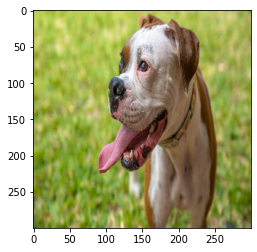

In [46]:
plt.imshow(x[1])

In [47]:
all_images = np.array(x)

In [48]:
print(all_images.shape)

(8, 300, 300, 3)


In [49]:
train_x, val_x = train_test_split(all_images, random_state = 42, test_size=0.25)

In [50]:
#now we will make input images by lowering resolution without changing the size
def pixalate_image(image, scale_percent = 40):
  width = int(image.shape[1] * scale_percent / 100)
  height = int(image.shape[0] * scale_percent / 100)
  dim = (width, height)

  small_image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
  
  # scale back to original size
  width = int(small_image.shape[1] * 100 / scale_percent)
  height = int(small_image.shape[0] * 100 / scale_percent)
  dim = (width, height)

  low_res_image = cv2.resize(small_image, dim, interpolation = cv2.INTER_AREA)

  return low_res_image

In [51]:
train_x_px = []

for i in range(train_x.shape[0]):
  temp = pixalate_image(train_x[i,:,:,:])
  train_x_px.append(temp)

train_x_px = np.array(train_x_px)


# get low resolution images for the validation set
val_x_px = []

for i in range(val_x.shape[0]):
  temp = pixalate_image(val_x[i,:,:,:])
  val_x_px.append(temp)

val_x_px = np.array(val_x_px)


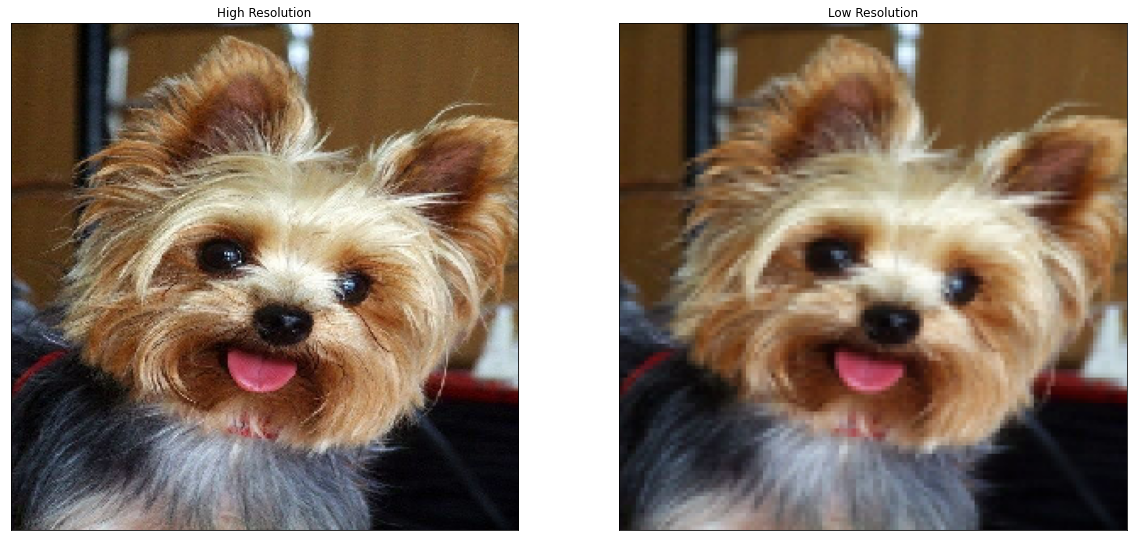

In [52]:
plt.figure(figsize= (20,10))

ax = plt.subplot(1,2,1)
plt.title('High Resolution')
plt.imshow(train_x[1])

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax = plt.subplot(1,2,2)
plt.title('Low Resolution')
plt.imshow(train_x_px[1])

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)


plt.show()

In [53]:
Input_img = Input(shape=(300, 300, 3))  
    
#encoding architecture
x1 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(Input_img)
x2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x1)
x3 = MaxPool2D(padding='same')(x2)

x4 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x3)
x5 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x4)
x6 = MaxPool2D(padding='same')(x5)

encoded = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x6)

# decoding architecture
x7 = UpSampling2D()(encoded)
x8 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x7)
x9 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x8)
x10 = Add()([x5, x9])

x11 = UpSampling2D()(x10)
x12 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x11)
x13 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x12)
x14 = Add()([x2, x13])

decoded = Conv2D(3, (3, 3), padding='same',activation='relu', kernel_regularizer=regularizers.l1(10e-10))(x14)

autoencoder = Model(Input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [61]:
autoencoder.summary()
early_stopper = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10, verbose=1, mode='min')
model_checkpoint = ModelCheckpoint('superResolution_checkpoint3.h5',save_best_only=True)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 300, 300, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 300, 300, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 150, 150, 64) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [62]:
history = autoencoder.fit(  train_x_px,train_x,
                            epochs=100,
                            validation_data=(val_x_px, val_x),
                            callbacks=[early_stopper, model_checkpoint]
                        )

Epoch 1/100
1/1 [==============================] - 28s 28s/step - loss: 0.0574 - accuracy: 0.6000 - val_loss: 0.0530 - val_accuracy: 0.4858
Epoch 2/100
1/1 [==============================] - 28s 28s/step - loss: 0.0544 - accuracy: 0.5481 - val_loss: 0.0428 - val_accuracy: 0.4456
Epoch 3/100
1/1 [==============================] - 28s 28s/step - loss: 0.0437 - accuracy: 0.5052 - val_loss: 0.0298 - val_accuracy: 0.4110
Epoch 4/100
1/1 [==============================] - 28s 28s/step - loss: 0.0301 - accuracy: 0.4629 - val_loss: 0.0189 - val_accuracy: 0.3750
Epoch 5/100
1/1 [==============================] - 28s 28s/step - loss: 0.0187 - accuracy: 0.4317 - val_loss: 0.0155 - val_accuracy: 0.3443
Epoch 6/100
1/1 [==============================] - 28s 28s/step - loss: 0.0153 - accuracy: 0.4155 - val_loss: 0.0203 - val_accuracy: 0.3566
Epoch 7/100
1/1 [==============================] - 28s 28s/step - loss: 0.0206 - accuracy: 0.4273 - val_loss: 0.0223 - val_accuracy: 0.4424
Epoch 8/100
1/1 [===

In [63]:
autoencoder_model = tf.keras.models.load_model('superResolution_checkpoint3.h5')

In [64]:
results = autoencoder.evaluate(val_x_px, val_x)
print('loss, accuracy', results)

1/1 [==============================] - 2s 2s/step - loss: 0.0012 - accuracy: 0.9372
loss, accuracy [0.0011931853368878365, 0.9372000098228455]


In [65]:
predictions = autoencoder_model.predict(val_x_px)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


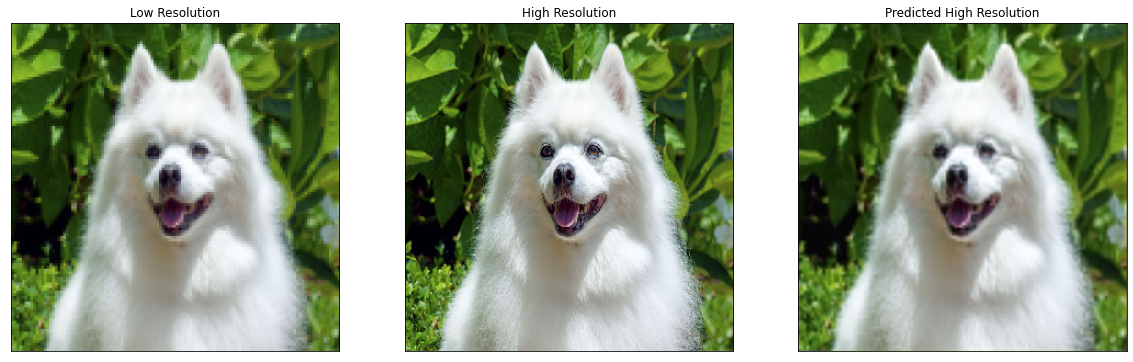

In [66]:
plt.figure(figsize= (20,10))

ax = plt.subplot(1,3,1)
plt.title('Low Resolution')
plt.imshow(val_x_px[1])

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax = plt.subplot(1,3,2)
plt.title('High Resolution')
plt.imshow(val_x[1])

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax = plt.subplot(1,3,3)
plt.title('Predicted High Resolution')
plt.imshow(predictions[1])

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)


plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


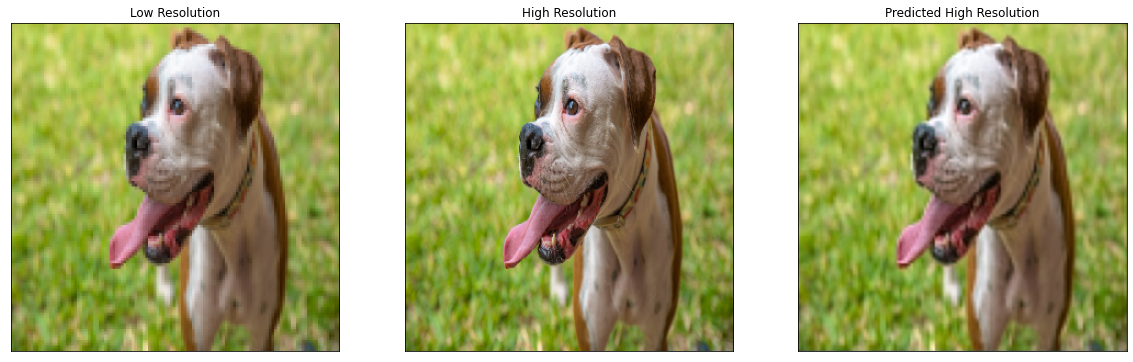

In [68]:
plt.figure(figsize= (20,10))

ax = plt.subplot(1,3,1)
plt.title('Low Resolution')
plt.imshow(val_x_px[0])

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax = plt.subplot(1,3,2)
plt.title('High Resolution')
plt.imshow(val_x[0])

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax = plt.subplot(1,3,3)
plt.title('Predicted High Resolution')
plt.imshow(predictions[0])

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)


plt.show()